In [32]:
!pip install ortools
!pip install pulp
!pip install pymongo
!pip install pylab-sdk
!pip install tabulate

import pprint
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.stats.api as sms
import pylab as py

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from statsmodels.graphics import tsaplots
from scipy import stats
from pulp import *
from random import shuffle
from random import randint
from random import randrange
from pymongo import MongoClient
from tabulate import tabulate

In [30]:
client = MongoClient('localhost', 27017) 
db = client['DataProject'] 
collection_trafic_stamped = db['vehicules_stamped']

# Graph generation

In [72]:
# Parameters of the graphe
nb_villes=10
tempsMax=200

def grapheVillesAleatoire(nbVilles, tempsMax):
    #La fonction créait une matrice donnant le temps entre chaque ville de manière aléatoire.
    graphe = np.random.choice(range(5,tempsMax), size=(nbVilles,nbVilles))
    for i in range(nbVilles): #La boucle s'exécute pour chaque ville (nbVilles) et ajoute la valeur dans la matrice
        graphe[i][i]= 0      
    grapheF = ((graphe + graphe.T - np.diag(graphe.diagonal()))/2).astype(int)
    return grapheF


start = time.time() #Commence à calculer le temps d'exécution
graphe = grapheVillesAleatoire(nb_villes,tempsMax) #Génère une matrice pour n villes (exemple:10) et ayant pour temps max. t minutes (exemple:200)
print(graphe)
stop = time.time() #Stop le calcul du temps d'exécution


[[  0  54 136  97  75 168 154  39 168 143]
 [ 54   0  53  70  83  52  86  64 128 154]
 [136  53   0  82 196 110 123 119 165 126]
 [ 97  70  82   0 178 110  30 121 142 141]
 [ 75  83 196 178   0 113  38  64  72  26]
 [168  52 110 110 113   0 111 112 128  88]
 [154  86 123  30  38 111   0 170 134 149]
 [ 39  64 119 121  64 112 170   0 137 155]
 [168 128 165 142  72 128 134 137   0 106]
 [143 154 126 141  26  88 149 155 106   0]]


In [27]:
def get_neighbors(path, graphe):
    start_node = path.pop(0)
    path.pop(len(path)-1)
    index=0
    for i in range(len(path)):
        for j in range(1,len(path)-i):
            neighbor_path=path.copy()
            neighbor_path[i], neighbor_path[i+j] = neighbor_path[i+j], neighbor_path[i]
            neighbor_path.insert(0,start_node)
            neighbor_path.append(start_node)
            yield(neighbor_path)

In [5]:
def get_path_cost(path, graphe):
    cost=0
    for i in range(len(path)-1):
        cost+=graphe[path[i]][path[i+1]]
    return cost

In [26]:
cities=["la rochelle","rochefort","saint-agnant","lagord","torcieu","replonges","corcelles","peron","relevant","chaveyriat","vaux-en-bugey","maillat","faramans","beon","saint-bernard","rossillon","pont-d-ain","nantua","chavannes-sur-reyssouze","neuville-les-dames","flaxieu","hotonnes","saint-sorlin-en-bugey","songieu","virieu-le-petit","saint-denis-en-bugey","charnoz-sur-ain","chazey-sur-ain","marchamp","culoz","mantenay-montlin","marboz","foissiat","treffort-cuisiat","izieu","saint-etienne-du-bois","hauteville-lompnes","saint-trivier-sur-moignans","peyriat","evosges","poncin","crans","montreal-la-cluse","cleyzieu","lompnieu","villereversure","saint-martin-du-mont","saint-genis-pouilly","bolozon","tarnos","lochieu","chanoz-chatenay","villebois","ceignes","saint-didier-sur-chalaronne","revonnas","bourg-saint-christophe","condeissiat","pirajoux","chalamont","plantay","versailleux","montagnat","vieu","saint-andre-de-corcy","landerneau","peronnas","colomieu","monthieux","saint-jean-sur-reyssouze","saint-agnant","montrevel-en-bresse","conand","challes-la-montagne","mogneneins","thoissey","chaleins","neuville-sur-ain","thil","jujurieux","oncieu","lurcy","balan","ambutrix","sainte-croix","blyes","conzieu","nievroz","nurieux-volognat","ambleon","saint-maurice-de-gourdans","chezery-forens","sault-brenaz","murs-et-gelignieux","petit-abergement","cormoz","saint-martin-de-bavel","saint-trivier-de-courtes","boyeux-saint-jerome","chateau-gaillard"]

def indexToCities(path):
    if len(path) <= len(cities):
        pathWithCities=list()
        for city in path:
            pathWithCities.append(cities[city])
    else:
        pathWithCities=path
    return pathWithCities

# **Nearest neighbor Algorithm**  <a name="4.2"></a>

In [53]:
def next_city(current_city_index,visited_cities_indexes,graphe) :
#La fonction donne l'indice de la ville la plus proche de celle d'indice actuel et qui n'a pas été visitée.
    mini = 1000000000
    minimum_index = -1
    for i in range(len(graphe)) :
        if visited_cities_indexes[i] == False :
            if graphe[current_city_index][i] < mini :
                mini = graphe[current_city_index][i]
                minimum_index = i
    return minimum_index

def nearest_neighbor(start_city,graphe):
    """ La fonction donne le chemin a suivre du voyageur de commerce sous forme d'un tableau d'indice."""
    visited_cities_indexes = [False] * len(graphe) # Au départ les villes ne sont pas visitées
    path = [0]* (len(graphe)) # Le chemin du voyageur au départ est vide.

    current_city_index = start_city # On trouve l'indice de la ville
    visited_cities_indexes[current_city_index] = True # On dit que la ville est visitée.
    path[0] = current_city_index

    for i in range(1,len(graphe)) :
        indice_next_city= next_city(current_city_index,visited_cities_indexes,graphe)
        path[i] = indice_next_city
        current_city_index = indice_next_city
        visited_cities_indexes[current_city_index] = True # La ville est visitée elle ne peut plus être prise.
    path.append(path[0])
    return path

res_nearest_neighbor=nearest_neighbor(0,graphe)

print("\nPath with only the nearest neighbor algorithm : " + str(res_nearest_neighbor))
print("")
print("Travel time : " + str(get_path_cost(res_nearest_neighbor,graphe)) + " mn, or " + str("{:.2f}".format(get_path_cost(res_nearest_neighbor,graphe)/60)) + " h")


Path with only the nearest neighbor algorithm : [0, 9, 1, 4, 7, 5, 8, 6, 3, 2, 0]

Length of the path : 537 mn, or 8.95 h


# **Tabu Algorithm**  <a name="4.3"></a>

The travel time of the initial path is: 1595 mn, or 26.58 h

---------------------------------------------

The best path found is: ['la rochelle', 'saint-trivier-sur-moignans', 'culoz', 'saint-bernard', 'saint-denis-en-bugey', 'relevant', 'lagord', 'rochefort', 'evosges', 'charnoz-sur-ain', 'peron', 'foissiat', 'peyriat', 'nantua', 'torcieu', 'saint-sorlin-en-bugey', 'treffort-cuisiat', 'pont-d-ain', 'flaxieu', 'izieu', 'marboz', 'hauteville-lompnes', 'hotonnes', 'mantenay-montlin', 'faramans', 'replonges', 'saint-etienne-du-bois', 'chavannes-sur-reyssouze', 'neuville-les-dames', 'corcelles', 'beon', 'marchamp', 'saint-agnant', 'virieu-le-petit', 'chaveyriat', 'songieu', 'rossillon', 'chazey-sur-ain', 'vaux-en-bugey', 'maillat', 'la rochelle']

Travel time : 1445 mn, or 24.08 h

Execution time : 10.677601099014282 seconds




Text(0.5, 1.0, '\nExploration of the search area by our algorithm\n')

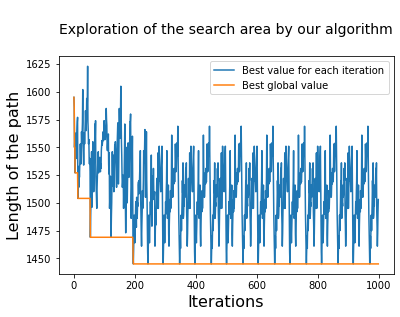

In [74]:
def tabu_search(start_node, tabu_length, iter_max, graphe, withNearestNeighbor):

    #Converting the starting city to an index
    try:
        start_node=cities.index(start_node)
    except:
        print("This city is not present in the graph, use the default city (la rochelle)\n")
        start_node=cities.index("la rochelle")
        
    nb_iter = 0
    tabu_list = list()

    # Here we use as initial path the result of our nearest neighbor algorithm
    if withNearestNeighbor==True:
        initial_element=nearest_neighbor(start_node,graphe)
    #We can also use a random initial path, for that, you have to uncomment the 2 lines below and comment the line above
    else:
        initial_element=[i for i in range(len(graphe))]
        initial_element.remove(start_node)
        initial_element.append(start_node)
        initial_element.insert(0,start_node)
        
    # solution variables for the search for the optimal non-taboo neighbor
    current_element = initial_element
    best_neighbor=current_element
    best_neighbor_global=current_element

    # variables values for the search of the optimal non-taboo neighbor
    best_cost=10000000000
    best_cost_global=10000000000

    # variables for display
    nb_tabou=0
    best_global_found=0
    
    # list of current and best solutions found, to display the trajectory
    paths=list()
    best_paths=list()
    
    while (nb_iter<iter_max):
        nb_iter += 1       
        best_cost=10000000000

        # we browse all the neighbors of the current solution
        for neighbor in get_neighbors(current_element,graphe):
            if get_path_cost(neighbor,graphe) < best_cost:
                if neighbor not in tabu_list:
                    best_cost = get_path_cost(neighbor,graphe)
                    best_neighbor = neighbor
          
        # we update the best solution encountered since the beginning
        if best_cost<best_cost_global:
            best_global_found+=1
            best_neighbor_global=best_neighbor
            best_cost_global=best_cost
            #print("Meilleur global trouvé ! : " + str(best_neighbor_global) + " avec une valeur de :" + str(best_cost_global))
      
        best_paths.append(best_cost_global)
        
        # we go to the best non-tabu neighbor found     
        current_element=best_neighbor.copy()
        paths.append(best_cost)
        
        # we update the tabu list
        tabu_list.append(best_neighbor)

        # we delete the oldest solution if the taboo list has reached its maximum size
        if len(tabu_list) > tabu_length:
            del tabu_list[0]

    # The city of origin is added to the initial element
    initial_element.insert(0,start_node)
    initial_element.append(start_node)
    return best_neighbor_global, paths, best_paths, initial_element

#------------------ Execution of the algorithm ---------------------

# Parameters for the generation of the cities
nb_cities=40
maxTime=200

#graphe2 = grapheVillesAleatoire(nb_cities,maxTime)

# Number of iterations
iter_maximum=1000
# Length of the tabu list
tabu_max=len(graphe2)
# Use the nearest neighbor for the initial path
useNearestNeighbor=True
# Edit this value to change the departure city
departure_city="la rochelle"

start_time = time.time()
sol, courants, meilleurs_courants, initial_path=tabu_search(start_node=departure_city, tabu_length=tabu_max, iter_max=iter_maximum, graphe=graphe2, withNearestNeighbor=useNearestNeighbor)
exec_time = (time.time() - start_time)

print("The travel time of the initial path is:",str(get_path_cost(initial_path,graphe2)) + " mn, or " + str("{:.2f}".format(get_path_cost(initial_path,graphe2)/60)) + " h")
print("\n---------------------------------------------")
print("\nThe best path found is: " + str(indexToCities(sol)))
print("\nTravel time : " + str(get_path_cost(sol,graphe2)) + " mn, or " + str("{:.2f}".format(get_path_cost(sol,graphe2)/60)) + " h")
print("\nExecution time : " + str(exec_time) + " seconds\n\n")

# Display the graphic
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Length of the path", fontsize=16)

res = plt.plot(range(iter_maximum), courants,label='Best value for each iteration')
res = plt.plot(range(iter_maximum), meilleurs_courants,label='Best global value')

plt.legend()
font2 = {'size':14}
plt.title("\nExploration of the search area by our algorithm\n", loc = 'center',fontdict = font2)

# **With Traffic**  <a name="4.4"></a>

In [9]:
vehicules_par_arretes = list(collection_trafic_stamped.aggregate([
    { "$group": 
     { "_id": "$num_arete",
      "nb_vehicules": { "$avg": "$nb_vehicules"} } },
    {"$sort" : { "_id":1 }}
]))

In [10]:
def transform_in_exponentiel(trafics):
    res = list()
    for i in trafics:
        res.append(round(math.exp(i*0.03)))
    return res

In [11]:
def add_traffic_time(graphe):
    
    trafics = [trafic["nb_vehicules"] for trafic in vehicules_par_arretes]

    trafics = trafics[:len(graphe)]
    graphe_with_traffic = graphe.copy()
    
    time_to_add_in_graphe = transform_in_exponentiel(trafics)
    
    for i in range(len(graphe)):
        for j in range(len(graphe)):
            if i != j:
                graphe_with_traffic[i][j] += time_to_add_in_graphe[j]
                
    return(graphe_with_traffic)

In [75]:
# Parameters for the generation of the cities
nb_villes=40
tempsMax=200

#graphe3 = grapheVillesAleatoire(nb_villes,tempsMax)

# Parameters for the tabu algorithm
iter_maximum=100
taille_tabou=len(graphe3)
useNearestNeighbor=True

# Departure city
departure_city="la rochelle"

print("\nExecution without traffic:\n")

start_time = time.time()
sol, courants, meilleurs_courants, initial_path=tabu_search(start_node=departure_city, tabu_length=taille_tabou, iter_max=iter_maximum, graphe=graphe3, withNearestNeighbor=useNearestNeighbor)
exec_time = (time.time() - start_time)

print("Travel time of the initial path is:",str(get_path_cost(initial_path,graphe3)) + " mn, or " + str("{:.2f}".format(get_path_cost(initial_path,graphe3)/60)) + " h")
print("\nThe best path found is:" + str(indexToCities(sol)))
print("\nIts travel time is: " + str(get_path_cost(sol,graphe3)) + " mn, or " + str("{:.2f}".format(get_path_cost(sol,graphe3)/60)) + " h")
print("\nExecution Time: " + str(exec_time) + " seconds")

print("\n-------------------------------------\n")

print("Execution with traffic:\n")

graphe_with_traffic = add_traffic_time(graphe3)

start_time = time.time()
sol, courants, meilleurs_courants, initial_path=tabu_search(start_node=departure_city, tabu_length=taille_tabou, iter_max=iter_maximum, graphe=graphe_with_traffic, withNearestNeighbor=useNearestNeighbor)
exec_time = (time.time() - start_time)

print("The travel time of the initial path is:",str(get_path_cost(initial_path,graphe_with_traffic)) + " mn, or " + str("{:.2f}".format(get_path_cost(initial_path,graphe_with_traffic)/60)) + " h")
print("\nThe best path found is: " + str(indexToCities(sol)))
print("\nIts travel time is: " + str(get_path_cost(sol,graphe_with_traffic)) + " mn, or " + str("{:.2f}".format(get_path_cost(sol,graphe_with_traffic)/60)) + " h")
print("\nExecution Time: " + str(exec_time) + " seconds")


Execution without traffic:

Travel time of the initial path is: 1479 mn, or 24.65 h

The best path found is:['la rochelle', 'corcelles', 'evosges', 'chaveyriat', 'mantenay-montlin', 'maillat', 'neuville-les-dames', 'foissiat', 'saint-bernard', 'beon', 'rochefort', 'peron', 'vaux-en-bugey', 'saint-trivier-sur-moignans', 'relevant', 'charnoz-sur-ain', 'culoz', 'izieu', 'chazey-sur-ain', 'rossillon', 'lagord', 'hotonnes', 'peyriat', 'nantua', 'songieu', 'virieu-le-petit', 'treffort-cuisiat', 'chavannes-sur-reyssouze', 'marchamp', 'saint-etienne-du-bois', 'saint-denis-en-bugey', 'saint-sorlin-en-bugey', 'torcieu', 'pont-d-ain', 'saint-agnant', 'hauteville-lompnes', 'replonges', 'flaxieu', 'marboz', 'faramans', 'la rochelle']

Its travel time is: 1359 mn, or 22.65 h

Execution Time: 1.3541169166564941 seconds

-------------------------------------

Execution with traffic:

The travel time of the initial path is: 1962 mn, or 32.70 h

The best path found is: ['la rochelle', 'corcelles', 'vau